#### Import Libraries

In [1]:
import glob
import cv2 as cv2
import numpy as np
import matplotlib.pyplot as plt
import random

#### Helper functions

In [338]:
def visualize(image_array):
    f,axes= plt.subplots(2,3, figsize=(20,10))
    f.subplots_adjust(hspace=0.5)
    row=0
    col=1
    for image in image_array:
        axes[row,col-1].imshow(image)
        col+=1
        if col%4==0:
            row+=1
            col=1
def load_images():
    image_list=[]
    images= glob.glob('./test_augmentation/*.jpg')
    for index in range(6):
        image= cv2.cvtColor(cv2.imread(images[index]),cv2.COLOR_BGR2RGB)
        image_list.append(cv2.resize(image,(1280,720)))
    
    return image_list

def load_image():
    image_list=[]
    images= glob.glob('./test_augmentation/*.jpg')
    image= cv2.cvtColor(cv2.imread(images[1]),cv2.COLOR_BGR2RGB)
    image_list.append(cv2.resize(image,(1280,720)))
    return image_list

#### Visualize test Images

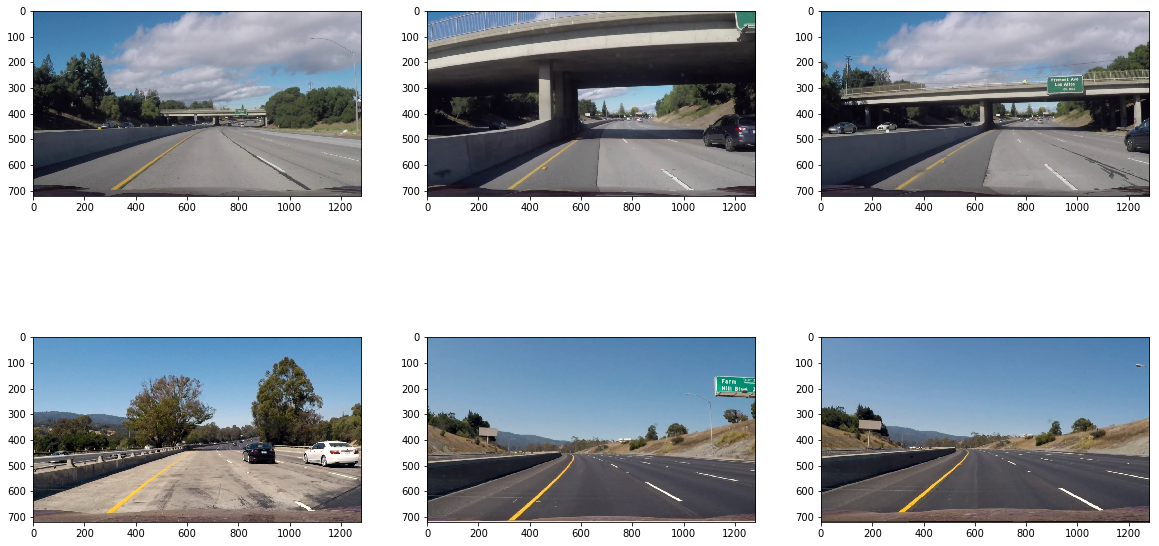

In [313]:
image_result=[]
for image in load_images():
    image_result.append(image)
visualize(image_result)

#### Function for adding random brightness (Sunny and shady Effect)

In [2]:
def add_brightness(image):
    image_HLS = cv2.cvtColor(image,cv2.COLOR_RGB2HLS) ## Conversion to HLS
    image_HLS = np.array(image_HLS, dtype = np.float64) 
    random_brightness_coefficient = np.random.uniform()+0.5 ## generates value between 0.5 and 1.5
    image_HLS[:,:,1] = image_HLS[:,:,1]*random_brightness_coefficient ## scale pixel values up or down for channel 1(Lightness)
    image_HLS[:,:,1][image_HLS[:,:,1]>255]  = 255 ##Sets all values above 255 to 255
    image_HLS = np.array(image_HLS, dtype = np.uint8)
    image_RGB = cv2.cvtColor(image_HLS,cv2.COLOR_HLS2RGB) ## Conversion to RGB
    return image_RGB

#### Visualizing brightness function

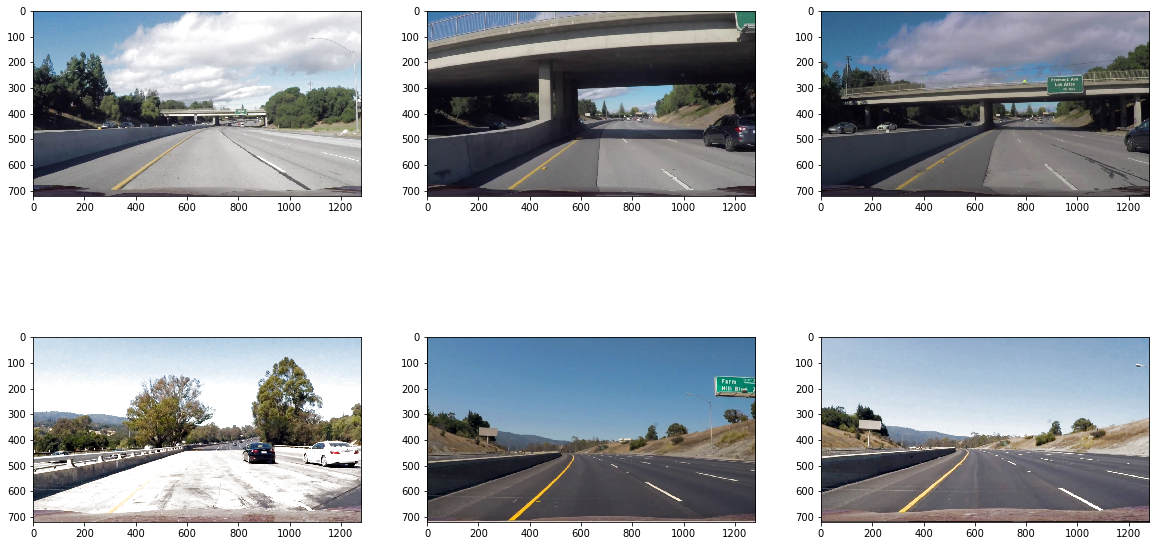

In [314]:
image_result=[]
for image in load_images():
    image_result.append(add_brightness(image))
visualize(image_result)

#### Function for adding random shadows

In [322]:
def generate_shadow_coordinates(imshape, no_of_shadows=1):
    vertices_list=[]
    for index in range(no_of_shadows):
        vertex=[]
        for dimensions in range(np.random.randint(3,15)): ## Dimensionality of the shadow polygon
            vertex.append(( imshape[1]*np.random.uniform(),imshape[0]//3+imshape[0]*np.random.uniform()))
        vertices = np.array([vertex], dtype=np.int32) ## single shadow vertices 
        vertices_list.append(vertices)
    return vertices_list ## List of shadow vertices
    
def add_shadow(image,no_of_shadows=1):
    image_HLS = cv2.cvtColor(image,cv2.COLOR_RGB2HLS) ## Conversion to HLS
    mask = np.zeros_like(image) 
    imshape = image.shape
    vertices_list= generate_shadow_coordinates(imshape, no_of_shadows) #3 getting list of shadow vertices
    for vertices in vertices_list: 
        cv2.fillPoly(mask, vertices, 255) ## adding all shadow polygons on empty mask, single 255 denotes only red channel
    
    image_HLS[:,:,1][mask[:,:,0]==255] = image_HLS[:,:,1][mask[:,:,0]==255]*0.5   ## if red channel is hot, image's "Lightness" channel's brightness is lowered 
    image_RGB = cv2.cvtColor(image_HLS,cv2.COLOR_HLS2RGB) ## Conversion to RGB
    return image_RGB

#### Visualizing shadow function

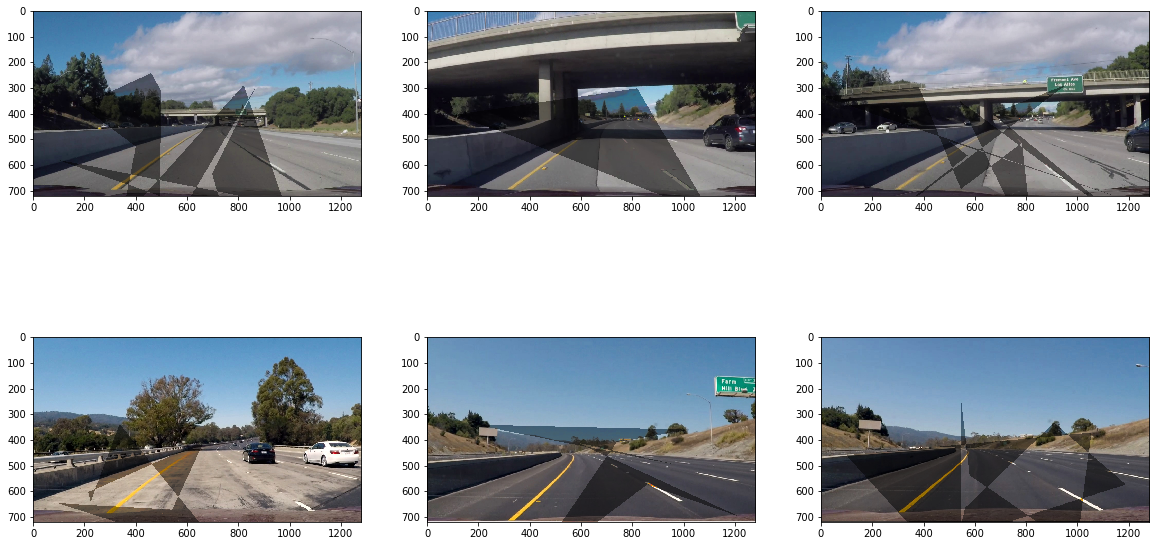

In [323]:
image_result=[]
for image in load_images():
    image_result.append(add_shadow(image))
visualize(image_result)

#### Function for adding snow

In [4]:
def add_snow(image):
    image_HLS = cv2.cvtColor(image,cv2.COLOR_RGB2HLS) ## Conversion to HLS
    image_HLS = np.array(image_HLS, dtype = np.float64) 
    brightness_coefficient = 2.5 
    snow_point=140 ## increase this for more snow
    image_HLS[:,:,1][image_HLS[:,:,1]<snow_point] = image_HLS[:,:,1][image_HLS[:,:,1]<snow_point]*brightness_coefficient ## scale pixel values up for channel 1(Lightness)
    image_HLS[:,:,1][image_HLS[:,:,1]>255]  = 255 ##Sets all values above 255 to 255
    image_HLS = np.array(image_HLS, dtype = np.uint8)
    image_RGB = cv2.cvtColor(image_HLS,cv2.COLOR_HLS2RGB) ## Conversion to RGB
    return image_RGB
    

#### Visualizing Snow function

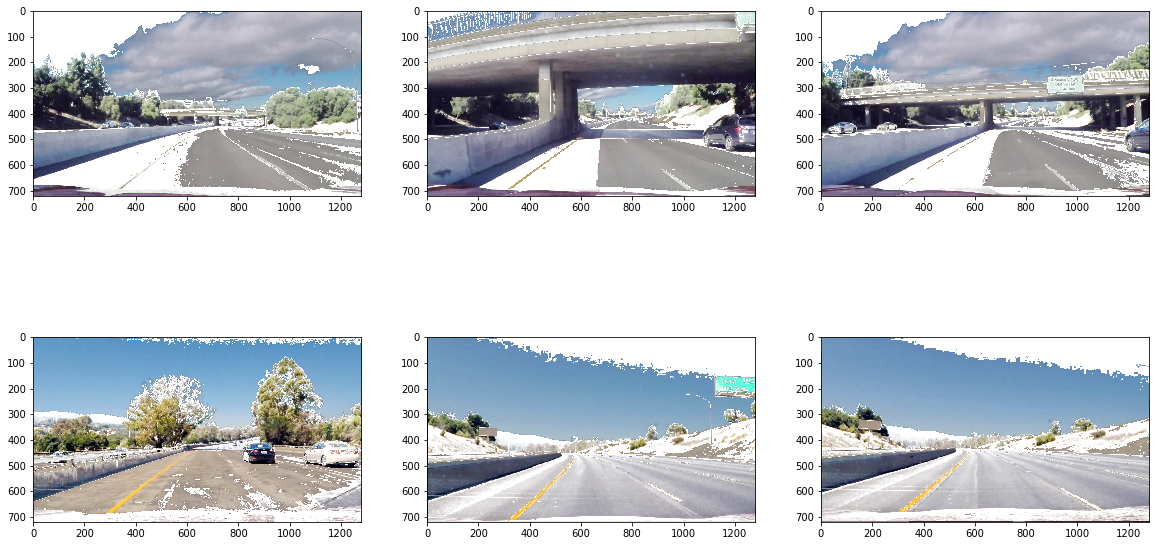

In [325]:
image_result=[]
for image in load_images():
    image_result.append(add_snow(image))
visualize(image_result)

#### Function for adding Rain

In [369]:
def generate_random_lines(imshape,slant,drop_length):
    drops=[]
    for i in range(1500): ## If You want heavy rain, try increasing this
        if slant<0:
            x= np.random.randint(slant,imshape[1])
        else:
            x= np.random.randint(0,imshape[1]-slant)
        y= np.random.randint(0,imshape[0]-drop_length)
        drops.append((x,y))
    return drops
        
    
def add_rain(image):
    
    imshape = image.shape
    slant_extreme=10
    slant= np.random.randint(-slant_extreme,slant_extreme) 
    drop_length=20
    drop_width=2
    drop_color=(200,200,200) ## a shade of gray
    rain_drops= generate_random_lines(imshape,slant,drop_length)
    
    for rain_drop in rain_drops:
        cv2.line(image,(rain_drop[0],rain_drop[1]),(rain_drop[0]+slant,rain_drop[1]+drop_length),drop_color,drop_width)
    image= cv2.blur(image,(7,7)) ## rainy view are blurry
    
    brightness_coefficient = 0.7 ## rainy days are usually shady 
    image_HLS = cv2.cvtColor(image,cv2.COLOR_RGB2HLS) ## Conversion to HLS
    image_HLS[:,:,1] = image_HLS[:,:,1]*brightness_coefficient ## scale pixel values down for channel 1(Lightness)
    image_RGB = cv2.cvtColor(image_HLS,cv2.COLOR_HLS2RGB) ## Conversion to RGB
    return image_RGB
    

#### Visualizing Rain function

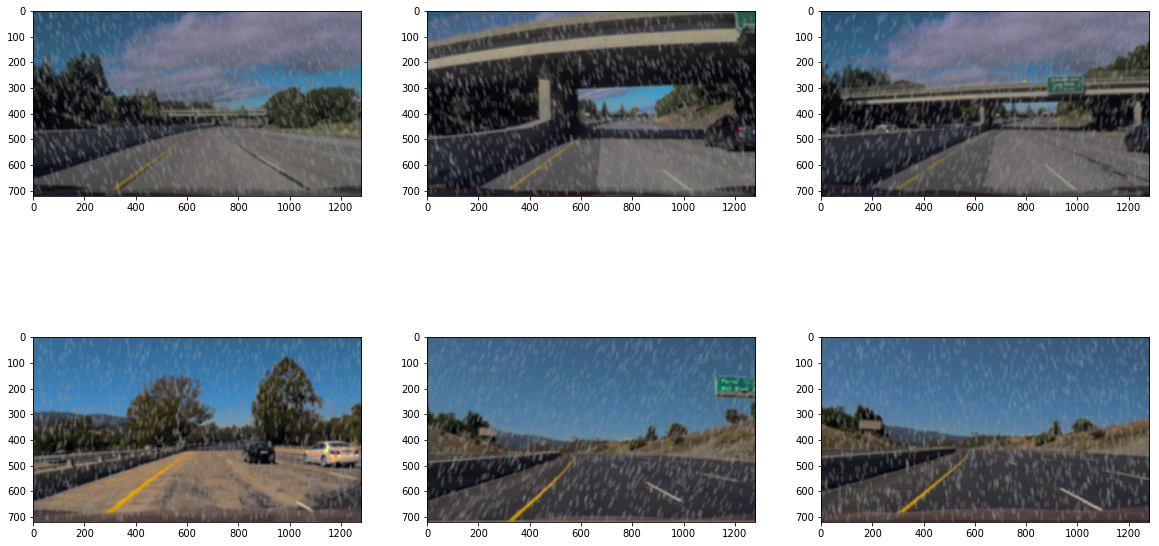

In [326]:
image_result=[]
for image in load_images():
    image_result.append(add_rain(image))
visualize(image_result)

#### Function for adding Fog

In [377]:
def add_blur(image, x,y,hw):
    image[y:y+hw, x:x+hw,1] = image[y:y+hw, x:x+hw,1]+1
    image[:,:,1][image[:,:,1]>255]  = 255 ##Sets all values above 255 to 255
    image[y:y+hw, x:x+hw,1] = cv2.blur(image[y:y+hw, x:x+hw,1] ,(10,10))
    return image

def generate_random_blur_coordinates(imshape,hw):
    blur_points=[]
    midx= imshape[1]//2-hw-100
    midy= imshape[0]//2-hw-100
    index=1
    while(midx>-100 or midy>-100):
        for i in range(300*index):
            x= np.random.randint(midx,imshape[1]-midx-hw)
            y= np.random.randint(midy,imshape[0]-midy-hw)
            blur_points.append((x,y))
        midx-=250*imshape[1]//sum(imshape)
        midy-=250*imshape[0]//sum(imshape)
        index+=1
    return blur_points
    
def add_fog(image):
    image_HLS = cv2.cvtColor(image,cv2.COLOR_RGB2HLS) ## Conversion to HLS
    mask = np.zeros_like(image) 
    imshape = image.shape
    hw=100
    image_HLS[:,:,1]=image_HLS[:,:,1]*0.8
    haze_list= generate_random_blur_coordinates(imshape,hw)
    for haze_points in haze_list: 
        image_HLS[:,:,1][image_HLS[:,:,1]>255]  = 255 ##Sets all values above 255 to 255
        image_HLS= add_blur(image_HLS, haze_points[0],haze_points[1], hw) ## adding all shadow polygons on empty mask, single 255 denotes only red channel
    image_RGB = cv2.cvtColor(image_HLS,cv2.COLOR_HLS2RGB) ## Conversion to RGB
    return image_RGB

#### Visualizing Fog Function

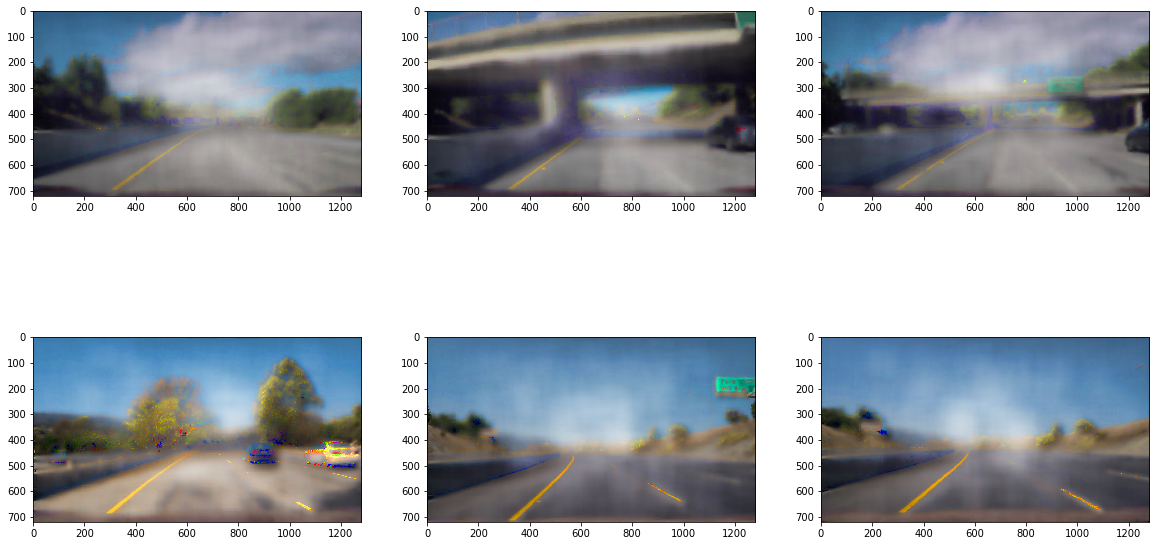

In [336]:
image_result=[]
for image in load_images():
    image_result.append(add_fog(image))
visualize(image_result)

#### Heavy Rain effect (low visibility)

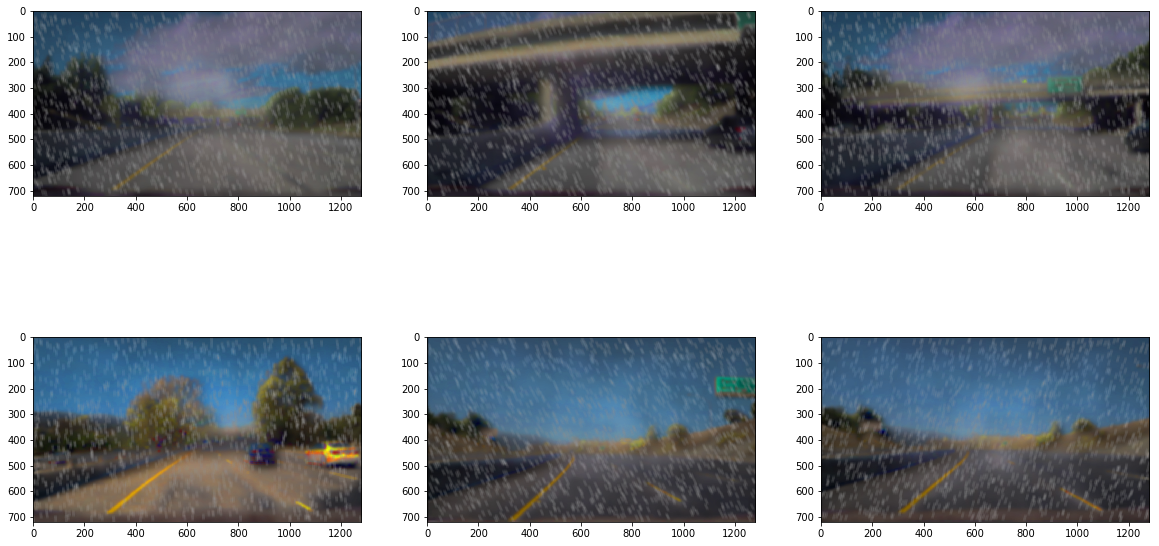

In [334]:
image_result=[]
for image in load_images():
    image_result.append(add_rain(add_fog(image)))
visualize(image_result)

In [379]:
# image_result=[]
# for image in load_image():
#     image_result.append(add_fog(add_fog(image)))
# plt.figure(figsize = (20,20))
# plt.imshow(image_result[0])